In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

In [2]:
stringSST = "300" ##295, 300 or 305
n_days = 1

#TOOCAN segmentation masks (les labels des objets MCS, dans la grille originale x,y,t)
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/TOOCAN_2.07_SAM_RCE_large'+stringSST+'_2D_irtb.nc'

# TOOCAN objects (list d'objets MCS, leur labels et leur caractéristiques)
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/FileTracking/TOOCAN-SAM_RCE_large'+stringSST+'_2D_irtb.dat.gz'

sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [3]:
MCS_labels = xr.open_dataarray(file_seg)
MCS_labels = MCS_labels.isel(time=slice(48*n_days))
MCS_labels

<xarray.DataArray 'MCS_label' (time: 48, latitude: 128, longitude: 2048)>
[12582912 values with dtype=float64]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:           
    standard_name:  MCS_label
    long_name:      MCS labellisation

# Import SAM, Compute Distrib, Store Bin localisations

In [4]:
ds_SAM = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_1.nc")
ds_SAM = ds_SAM.isel(time=slice(48*n_days)) #.isel(x=slice(64, None))
ds_SAM["x"] = ((ds_SAM["x"])/3e3).astype(int)
ds_SAM["y"] = (ds_SAM["y"]/3e3).astype(int) 
ds_SAM["time"] = np.round(((ds_SAM["time"]-75)*48)).astype(int) 
print(ds_SAM)

ds_SAM_shape= ds_SAM["Prec"].shape
#ds_SAM_Prec = ds_SAM["Prec"].stack(flat=('time', 'y', 'x')).to_numpy()
#ds_SAM_Prec.reshape(ds_SAM_shape)[226, 76, 1747] ## to retrieve the PRec in original shape or ds_SAM["Prec"].to_numpy()
dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 6, fill_last_decade=True)
dist_SAM_Prec.computeDistribution(sample = ds_SAM["Prec"].stack(flat=('time', 'y', 'x')).to_numpy())
dist_SAM_Prec.storeSamplePoints(sample = ds_SAM["Prec"].stack(flat=('time', 'y', 'x')).to_numpy(), sizemax = None)
SAM_Prec_bin_loc = dist_SAM_Prec.bin_locations

<xarray.Dataset>
Dimensions:   (x: 2048, y: 128, time: 48)
Coordinates:
  * x         (x) int64 0 1 2 3 4 5 6 7 ... 2041 2042 2043 2044 2045 2046 2047
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
Data variables: (12/69)
    Prec      (time, y, x) float32 ...
    SHF       (time, y, x) float32 ...
    LHF       (time, y, x) float32 ...
    LWNS      (time, y, x) float32 ...
    LWNSC     (time, y, x) float32 ...
    LWNT      (time, y, x) float32 ...
    ...        ...
    rsuscs    (time, y, x) float32 ...
    hadvfmse  (time, y, x) float32 ...
    vadvfmse  (time, y, x) float32 ...
    advfmse   (time, y, x) float32 ...
    VIH_inst  (time, y, x) float32 ...
    var_h_in  (time, y, x) float32 ...


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [5]:
## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
label_list = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file

def idx_by_label(labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

(2, [0], [8])
(2, [0], [10])
(2, [0], [15])
(2, [0], [8])
(2.1, [0, 14], [6, 15])
(2, [0], [9])
(2, [0], [8])
(2, [0], [9])
(2, [0], [11])
(2, [0], [10])


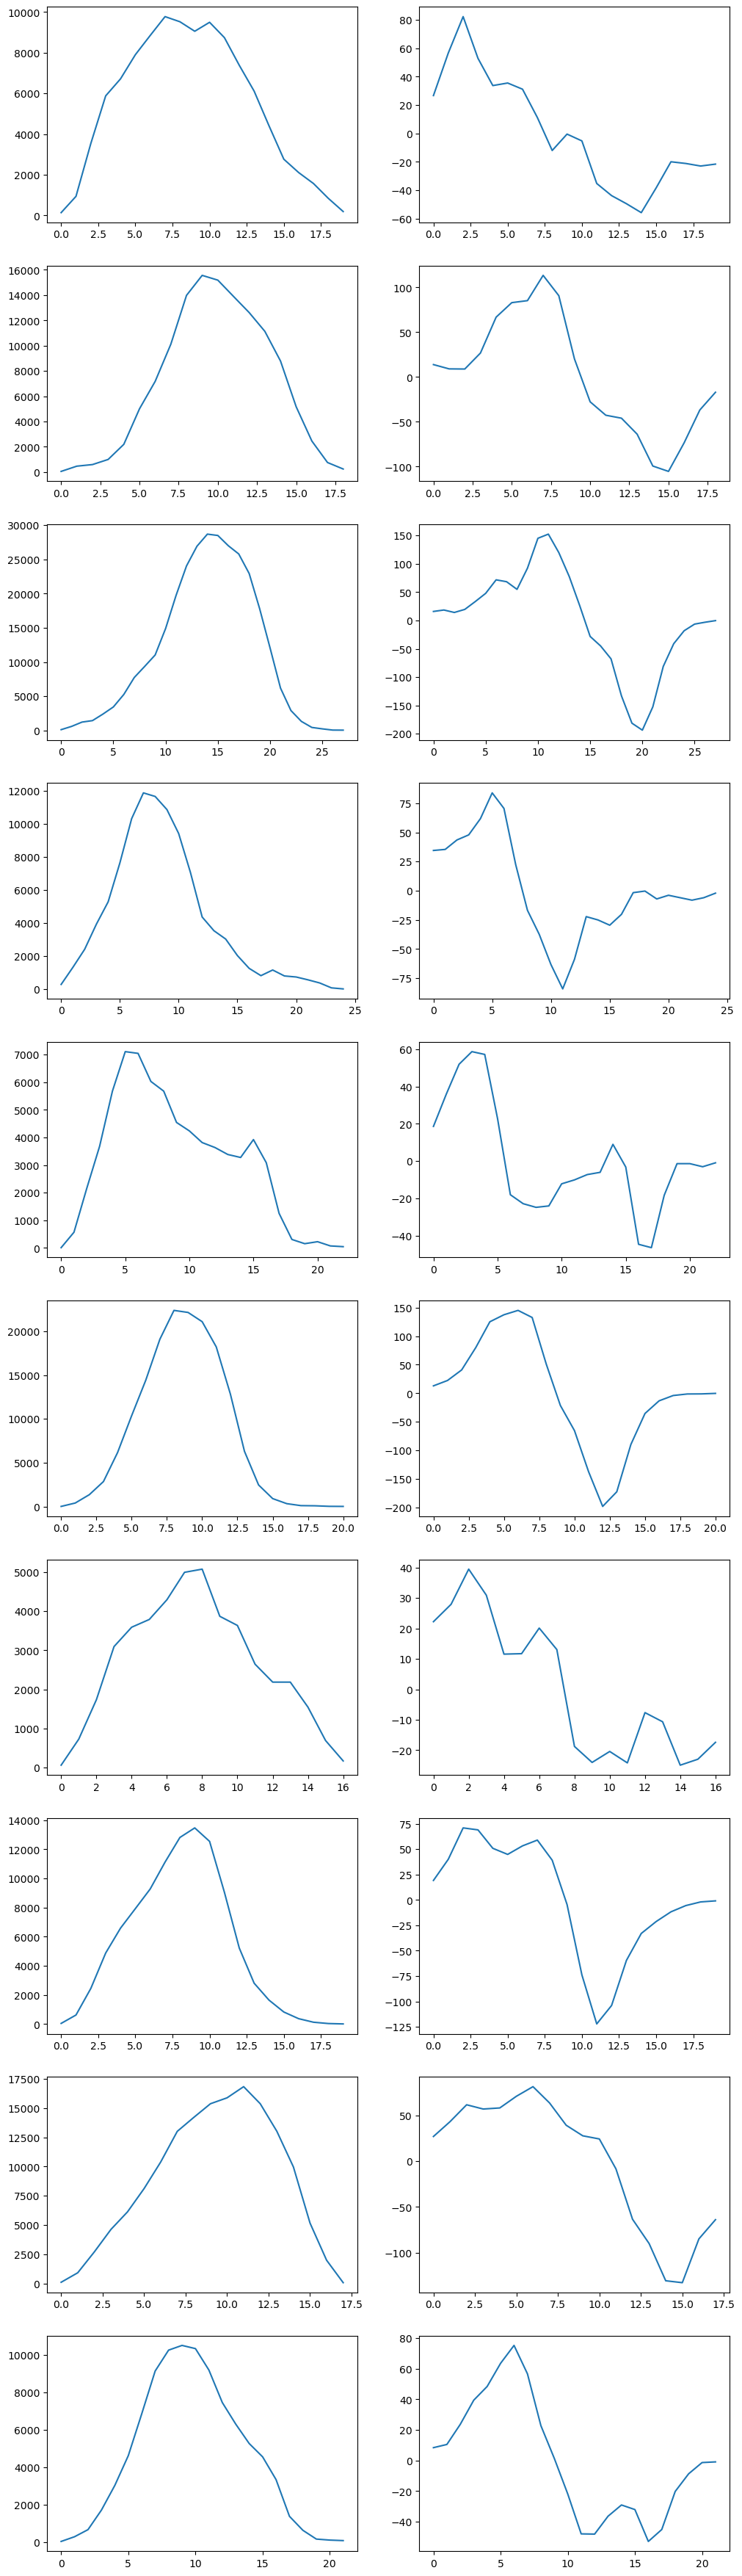

In [6]:
fig, axs = plt.subplots(ncols = 2, nrows = 10, figsize = (2*6, 10* 4.5))
from myFuncs import calculate_first_derivative, classify_derivative
for i, ax1, ax2 in zip(range(10), axs[:,0].flatten(), axs[:,1].flatten()): 
    surf = np.array(MCS[i].clusters.surf235k_km2)  ## normally index by label here
    dsurf = calculate_first_derivative(surf)
    ax1.plot(surf)
    ax2.plot(dsurf)
    MClass, pos, neg = classify_derivative(dsurf)
    print(MClass)
    if (MClass==2) or MClass == 1 :
        mean_growth = np.mean(dsurf[dsurf>0])
        max_growth = np.max(dsurf[dsurf>0])
    elif MClass==2.1:
        mean_growth = np.mean(dsurf[pos[0]:neg[0]])
        max_growth = np.max(dsurf[pos[0]:neg[0]])
plt.show()